# Theme:  Statistical Related Risk: Volatility & Statistical Related Risk: Correlation

# Statistics

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
# from ydata_profiling import ProfileReport
# from IPython.display import IFrame

#statistical tests
import statsmodels.api as sm
from scipy import stats

In [ ]:
#import yfinance as yf

btcusdt_ticker = "BTC-USD"
start_date = "2020-01-01"
end_date = "2023-04-25"

df = yf.download(btcusdt_ticker, start=start_date, end=end_date)
print(df.head())


[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  7194.892090  7254.330566  7174.944336  7200.174316  7200.174316   
2020-01-02  7202.551270  7212.155273  6935.270020  6985.470215  6985.470215   
2020-01-03  6984.428711  7413.715332  6914.996094  7344.884277  7344.884277   
2020-01-04  7345.375488  7427.385742  7309.514160  7410.656738  7410.656738   
2020-01-05  7410.451660  7544.497070  7400.535645  7411.317383  7411.317383   

                 Volume  
Date                     
2020-01-01  18565664997  
2020-01-02  20802083465  
2020-01-03  28111481032  
2020-01-04  18444271275  
2020-01-05  19725074095  


In [ ]:
# installing additional package for desriptive statistics in html format
!pip install ydata_profiling

import ydata_profiling as ypr
from ydata_profiling import ProfileReport

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_btc = df

returns_btc = df

profile = ProfileReport(df_btc)
profile.to_file('df_btc.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile

I am interested only in the information in df_btc[‘Adj Close’], and I will use it for further analysis. So, in case you are interested in the other columns like: Open, High, Low, Close or Volume, the same type of analysis can be applied towards them as well.
Let’s do some statistical evaluations to prove whether the data is normally distributed. I will use the visual method called: “Q-Q Plot”.
Here you can see that the data is NOT normally distributed because otherwise it should be very close to the 45-degree line added to the plot (because normally distributed data do so).


In [ ]:


returns_btc['returns'] = df['Adj Close'].pct_change()
returns_btc = returns_btc.dropna()

profile_returns = ProfileReport(returns_btc)
profile_returns

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

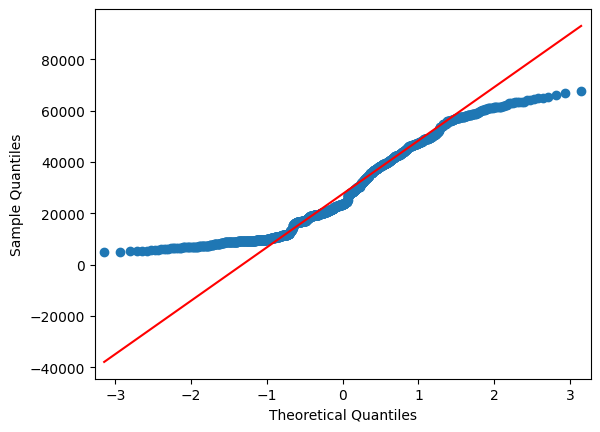

In [ ]:
# import statsmodels.api as sm

# create Q-Q plot with 45-degree line added to the plot
"""
this plot can be uset for seen the qqplo of:
- returns_btc['Adj Close']
- returns_btc['returns']
"""
fig = sm.qqplot(returns_btc['Adj Close'], line='q')
plt.show()

Visualizations are not exactly scientific proof for anything because every human being has his own interpretations and abstract thinking, and it is possible for someone not to be able to see it as it is.
In this case I will use the very formal statistical test: Shapiro-Wilk test and it will mathematically (statistically) prove or not whether there is a normal distribution.
If the value of the Shapiro test's p-value is less than 0.05. This means that with 95% confidence the data is NOT normally distributed


In [ ]:
#from scipy import stats

# perform Shapiro-Wilk test
shapiro_test = stats.shapiro(returns_btc['returns'])
print(shapiro_test)


ShapiroResult(statistic=0.9171086549758911, pvalue=3.349220646237701e-25)


So, what can we do in this case?

 I will try to normalize the data be using the so called numpy.log() method which is a simple logarithm transformation over all the values in the data.

 And the I will use once more the previous methods to check for normallity

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



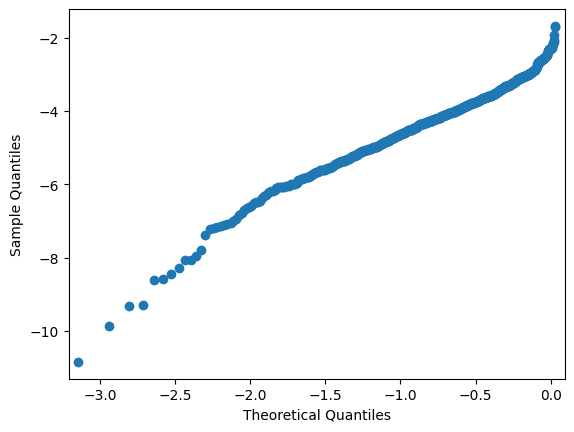

In [ ]:
logged_btc = np.log(returns_btc['returns'])

fig = sm.qqplot(logged_btc)
plt.show()



In [ ]:
# perform Shapiro-Wilk test
shapiro_test = stats.shapiro(logged_btc)
print(shapiro_test)

ShapiroResult(statistic=nan, pvalue=1.0)



And now with a p-value of 1 from the Shapiro Wilk test for normallity we can say that the loged data of Bitcoin returns is normally distributed with very few outliers in the tails.

# Correlations 

In [ ]:
!pip install statsmodels
!pip install pmdarima
!pip install vectorbt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.tsatools import lagmat2ds
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
import vectorbt as vbt
import pmdarima as pmd
from scipy.ndimage import shift
import plotly.graph_objects as go

In [ ]:

df = yf.download("BTC-USD", start="2020-01-01", end="2023-04-25")

df_10yt = yf.download("^TNX", start="2020-01-01", end="2023-04-25")[['Adj Close']].rename(columns={'Adj Close': 'US_10_Year_Treasury_Yield'})
df_10yt['US_10_Year_Treasury_Yield'] *= 0.01
df = df.join(df_10yt, how='left')
df = df.dropna(subset=['US_10_Year_Treasury_Yield'])
df['Return'] = df['Adj Close'].pct_change()
df.index = pd.to_datetime(df.index)
df = df[['Return', 'US_10_Year_Treasury_Yield']].iloc[1:].copy()

df['Return'].describe()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


count    832.000000
mean       0.002676
std        0.044690
min       -0.371695
25%       -0.016921
50%        0.001386
75%        0.022990
max        0.211097
Name: Return, dtype: float64

In [ ]:
df

Return  US_10_Year_Treasury_Yield
Date                                           
2020-01-03  0.051452                    0.01788
2020-01-06  0.057773                    0.01811
2020-01-07  0.050774                    0.01827
2020-01-08 -0.010269                    0.01874
2020-01-09 -0.024851                    0.01858
...              ...                        ...
2023-04-18  0.032349                    0.03572
2023-04-19 -0.051809                    0.03602
2023-04-20 -0.020008                    0.03545
2023-04-21 -0.034309                    0.03570
2023-04-24  0.009108                    0.03515

[832 rows x 2 columns]

Augmented Dickey–Fuller test:
The testing procedure for the ADF test is the same as for the Dickey–Fuller test [16] but it is applied to the model

$\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p-1} \delta_i \Delta y_{t-i} + \epsilon_t$

The unit root test is then carried out under the null hypothesis 𝛾 = 0 [17]

To ensure the stability of the results, it is essential to verify that both time series are stationary before conducting a Granger causality analysis. We will employ the Augmented Dickey-Fuller (ADF) test to confirm stationarity, with the p-value being used as a threshold, where a value exceeding 0.05 indicates non-stationarity.


In [ ]:
for col in ['US_10_Year_Treasury_Yield', 'Return']:
    p_value = adfuller(df[col])[1]
    if p_value > 0.05:
        print(f'{col} is nonstationary with p-value {p_value}, so we need to do difference of the return')
    else:
        print(f'{col} is stationary with p-value {p_value}')

US_10_Year_Treasury_Yield is nonstationary with p-value 0.9419752839401622, so we need to do difference of the return
Return is stationary with p-value 1.797948926210907e-17


In [ ]:
df['US_10_Year_Treasury_Yield'] = df['US_10_Year_Treasury_Yield'].diff()
df = df.rename(columns={'US_10_Year_Treasury_Yield': f'US_10_Year_Treasury_Yield_diff_1'})
df = df.dropna(subset=['US_10_Year_Treasury_Yield_diff_1'])
p_value = adfuller(df['US_10_Year_Treasury_Yield_diff_1'])[1]
print(p_value)

6.883099792070528e-13


In [ ]:
split_point = int(0.2*len(df))
df_test = df.iloc[-split_point:]
df = df.iloc[:-split_point]
print(f"df length: {len(df)}, df_test length: {len(df_test)}")

df length: 665, df_test length: 166


In [ ]:
def create_corr_plot(df, factor='', plot_pacf=False):
    """
    Code source: https://community.plotly.com/t/plot-pacf-plot-acf-autocorrelation-plot-and-lag-plot/24108/3 
    """
    series = df[factor]
    corr_array = pacf(series.dropna(), nlags=100, alpha=0.05) if plot_pacf else acf(series.dropna(), nlags=100, alpha=0.05)
    corr_array = (corr_array[0][1:], corr_array[1][1:])

    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines', fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title=f'Partial Autocorrelation (PACF): {factor}' if plot_pacf else f'Autocorrelation (ACF): {factor}'
    fig.update_layout(title=title, width=600, height=400)
    fig.show()

In [ ]:
create_corr_plot(df, 'Return', True)
create_corr_plot(df, 'Return', False)
create_corr_plot(df, 'US_10_Year_Treasury_Yield_diff_1', True)
create_corr_plot(df, 'US_10_Year_Treasury_Yield_diff_1', False)

We can observe that there were no outliers in the earlier periods, but a persistent pattern of non-decay and frequent outliers outside of the range appeared in the later periods.

If we observe the correlation between US Treasury bond yields and Bitcoin we can see that there is no obvious relationship. However, we should do granger causality after we consider each lags of themself

In [ ]:

corr_array = ccf(df['Return'], df['US_10_Year_Treasury_Yield_diff_1'])[:200]
fig = go.Figure()
fig.add_scatter(x=np.arange(len(corr_array)), y=corr_array, mode='markers', marker_color='#1f77b4',
               marker_size=6)
fig.update_traces(showlegend=False)

title=f"Cocorrelation of {' and '.join(df.columns)}"
fig.update_layout(title=title, width=600, height=400)
fig.show()

X Granger-causes Y if the addition of the lagged values of X to the prediction of Y improves the prediction of Y, where the prediction is made using a linear regression model of the form:

$Y_{t} = \alpha + \sum_{i=1}^{p} \beta_i Y_{t-i} + \sum_{i=1}^{q} \gamma_i X_{t-i} + \epsilon_t$

Granger causality is a statistical technique used to determine whether a time series X can predict future values of another time series Y. Specifically, X is said to Granger-cause Y if past values of X, along with past values of Y, are statistically significant predictors of future values of Y. This is typically established using t-tests and F-tests on lagged values of X and Y.[15]


In [ ]:
MAX_LAG = 100
result = grangercausalitytests(df, MAX_LAG, verbose=False)

for i in range(1, MAX_LAG + 1):
    if all(pvalue < 0.05 for pvalue in [r[1] for r in result[i][0].values()]):
        break
print(f"The lag number we consider to form the AR model with max lags = {i}")
print(result[i])

The lag number we consider to form the AR model with max lags = 47
({'ssr_ftest': (1.4640301942385112, 0.027184323824048208, 523.0, 47), 'ssr_chi2test': (81.30826199206845, 0.001399444187643585, 47), 'lrtest': (76.38677255885659, 0.004304714295519853, 47), 'params_ftest': (1.4640301942385097, 0.02718432382404904, 523.0, 47.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f15644e7df0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f15644e4eb0>, array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])])


In [ ]:
train_data = lagmat2ds(df.values, i, trim="both", dropex=1)

model = OLS(train_data[:, 0], add_constant(train_data[:, 1:], prepend=False)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     1.404
Date:                Mon, 01 May 2023   Prob (F-statistic):             0.0119
Time:                        14:58:59   Log-Likelihood:                 1109.3
No. Observations:                 618   AIC:                            -2029.
Df Residuals:                     523   BIC:                            -1608.
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0560      0.041     -1.364      0.173      -0.137       0.025
x2             0.0745      0.041      1.821      0.069      -0.006       0.155
x3             0.0513      0.041      1.250      0.212      -0.029       0.132
x4            -0.0222      0.041     -0.542      0.588      -0.103       0.058
x5            -0.0815      0.041     -1.989      0.047      -0.162      -0.001
x6            -0.0223      0.041     -0.542      0.588      -0.103       0.059
x7             0.1346      0.041      3.268      0.001       0.054       0.216
x8            -0.0637      0.042     -1.530      0.127      -0.146       0.018
x9            -0.0047      0.042     -0.112      0.911      -0.087       0.077
x10            0.0174      0.042      0.414      0.679      -0.065       0.100
x11            0.0728      0.042      1.732      0.084      -0.010       0.155
x12           -0.0754      0.042     -1.790      0.074      -0.158       0.007
x13            0.0268      0.042      0.634      0.526      -0.056       0.110
x14            0.0350      0.042      0.827      0.409      -0.048       0.118
x15           -0.0417      0.042     -0.989      0.323      -0.124       0.041
x16           -0.0378      0.042     -0.899      0.369      -0.121       0.045
x17           -0.0295      0.042     -0.699      0.485      -0.112       0.053
x18            0.0459      0.042      1.094      0.274      -0.036       0.128
x19            0.0735      0.042      1.753      0.080      -0.009       0.156
x20           -0.0324      0.042     -0.771      0.441      -0.115       0.050
x21           -0.0036      0.042     -0.085      0.933      -0.086       0.079
x22            0.1019      0.042      2.433      0.015       0.020       0.184
x23            0.0362      0.042      0.860      0.390      -0.047       0.119
x24           -0.0106      0.042     -0.251      0.802      -0.093       0.072
x25           -0.0101      0.042     -0.239      0.811      -0.093       0.073
x26            0.0413      0.042      0.984      0.326      -0.041       0.124
x27            0.0470      0.042      1.113      0.266      -0.036       0.130
x28            0.0245      0.042      0.578      0.564      -0.059       0.108
x29           -0.0107      0.042     -0.254      0.800      -0.094       0.072
x30            0.0538      0.042      1.278      0.202      -0.029       0.137
x31           -0.0117      0.042     -0.278      0.781      -0.094       0.071
x32           -0.0094      0.042     -0.223      0.824      -0.092       0.073
x33           -0.0653      0.042     -1.549      0.122      -0.148       0.018
x34            0.0098      0.042      0.232      0.817      -0.073       0.093
x35           -0.0324      0.042     -0.764      0.445      -0.116       0.051
x36            0.0386      0.042      0.917      0.359      -0.044       0.121
x3

In [ ]:
test_data = lagmat2ds(df_test.values, i, trim="both", dropex=1)

y = pd.Series(test_data[:, 0])
yhats = pd.Series(model.predict(add_constant(test_data[:, 1:], prepend=False)))


In [ ]:
train_return_describe = pd.Series(model.predict()).describe()
train_return_describe

count    618.000000
mean       0.003379
std        0.020208
min       -0.077180
25%       -0.008667
50%        0.002950
75%        0.014720
max        0.096807
dtype: float64

In [ ]:
y_model_adjusted = y.copy()
y_model_adjusted[yhats < train_return_describe['25%']] = 0.
y_model_adjusted.vbt.returns(freq='d').plot_cumulative(benchmark_rets=y).show()

In [ ]:
y_model_adjusted.vbt.returns(freq='d').stats(settings=dict(benchmark_rets=y))

Start                                        0
End                                        118
Period                       119 days 00:00:00
Total Return [%]                     57.927419
Benchmark Return [%]                 34.297639
Annualized Return [%]               306.176036
Annualized Volatility [%]            61.704038
Max Drawdown [%]                     10.266098
Max Drawdown Duration         43 days 00:00:00
Sharpe Ratio                          2.568081
Calmar Ratio                         29.823993
Omega Ratio                            1.66534
Sortino Ratio                         5.378637
Skew                                  2.242645
Kurtosis                             12.329672
Tail Ratio                            1.704727
Common Sense Ratio                    6.924192
Value at Risk                        -0.030879
Alpha                                 1.088425
Beta                                  0.730401
dtype: object

# REFERENCES:


1.       Harsch Katara and Dheeraj Vaidya, Quartile Formula, WallStreetMojo,  Quartile Formula | How to Calculate Quartile in Statistics | Example (wallstreetmojo.com)
2.      Pritha Bhandari, How to find the Median, Scribbr, 02/19/2023,  How to Find the Median | Definition, Examples & Calculator (scribbr.com)
3.       Median - Formula, Meaning, Example | How to Find Median? (cuemath.com)
4.       Quantile: Definition and How to Find Them in Easy Steps - Statistics How To
5.       Avijeet Biswal, SimpleLearn, 04/03/2023, Percentile in Statistics: Overview & How to Calculate | Simplilearn
6.       Jim Frost, Statistics by Jim, Interquartile Range (IQR): How to Find and Use It - Statistics By Jim
7.       Khan Academy, Calculating standard deviation step by step, Standard deviation: calculating step by step (article) | Khan Academy
8.       Adam Hayes, Somer Anderson, Amanda Bellucco-Chatham, Co-efficient of Variation Meaning and How to Use It, Investopedia 09/16/2022, Co-efficient of Variation Meaning and How to Use It (investopedia.com)
9.      Khan Academy; Mean, median and mode;  Mean, median, and mode review (article) | Khan Academy
10.   Statistics How To, Median Absolute Deviation, Median Absolute Deviation - Statistics How To
11.   Ashish Kumar Srivastav, Dheeraj Vaidya, Skewness Formula, WallStreetMojo, Skewness Formula | How to Calculate Skewness? (with Examples) (wallstreetmojo.com)
12.   Diksha Keni, Dheeraj Vaidya, Population Variance Formula, WallStreetMojo, Population Variance Formula | Step by Step Calculation | Examples (wallstreetmojo.com)
13.    Dybvig, Philip H., and William J. Marshall. “The New Risk Management: The Good, the Bad, and the Ugly.” Economic Research Federal Reserve Bank of St. Louis, vol. 79, no. 6, 1997, pp.9-21,https://research.stlouisfed.org/publications/review/1997/11/01/the-new-risk-management-the-good-the-bad-and-the-ugly. Accessed 30 April 2023. 
14. Partial Auto Correlation Function Formula
15. Granger_causality
16. Dickey–Fuller test
17. Augmented Dickey–Fuller test
18. Leslie, J. R., Stephens, M. A., and Fotopoulos, S. (1986). Asymptotic distribution of the Shapiro–Wilk W for testing for normality. Ann.Statist. 14, 1497–1506


